# Capstone Project-Final Assignment IBM

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

### Introduction: Business Problem <a name="introduction"></a>

#### A description of the problem and a discussion of the background

**Scenario**: More and more Greek people visit or inhabit to Canada and more specifically in the greater area of Toronto. 
It will be interesting to examine:
1. If there are opportunities for entrepreneurs to invest and open a new Greek restaurant but also finding the ideal neighbohoods within the greater area of Toronto. 
2. From an academic perspective it will be interesting to test our hypothesis and identify if entrepreneurs tend to spot such opportunities.

### Data <a name="data"></a>

The main idea here is to select a place where there will be no or at least only a few Greek restaurants in order to ensune that there is an open spot for a new restaurant.  
In addition, a secondary target is to identify the densely populated areas with Greek people which may indicate the existance of many possible customers.

Necessary data:  
**1)** Inforamtion from wikipedia regarding [neighborhoods](https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M) in Toronto.

**2)** *Geospatial_Coordinates.csv* provided from instructors during this course.

**3)** Inforamtion from wikipedia regarding the [population](https://en.m.wikipedia.org/wiki/Demographics_of_Toronto#Ethnic_diversity) of Toronto.

**4)** Finally, information regarding the established restaurants in Toronto will be retieved from **Foursquare API**.  

Additional data needed during the study:  
**1)** The [postal codes](http://www.ezpostalcodes.com/street/ONTARIO/TORONTO/DANFORTH) from the *Toronto - Danforth* district of Toronto.

##### Importing main libraries

In [1]:
!conda install -c conda-forge wikipedia --yes 

import wikipedia as wp
import numpy as np
import pandas as pd
import json
import requests 
from pandas.io.json import json_normalize 
import matplotlib.cm as cm
import matplotlib.colors as colors
!pip install geocoder 
import geocoder
import os, types
from botocore.client import Config
import ibm_boto3

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim 

from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes
import folium

!pip install bs4

from bs4 import BeautifulSoup
!conda install -c districtdatalabs yellowbrick

from yellowbrick.cluster import KElbowVisualizer

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python-3.7-OpenCE

  added / updated specs:
    - wikipedia


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2021.5.30          |   py37h89c1867_0         141 KB  conda-forge
    openssl-1.1.1k             |       h7f98852_0         2.1 MB  conda-forge
    python_abi-3.7             |          2_cp37m           4 KB  conda-forge
    wikipedia-1.4.0            |             py_2          13 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.3 MB

The following NEW packages will be INSTALLED:

  python_abi         conda-forge/linux-64::python_abi-3.7-2_cp37m
  wikipedia          conda-forge/noarch::wikipedia-1.4.0-py_2

The following packages will be SUPERSEDED by a higher-priority channel:

  certifi      

#### Importing Neighborhood Data of Toronto

In [2]:
url= "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
data  = requests.get(url).text
soup = BeautifulSoup(data,"html5lib")

#find the html table in the web page
table_contents=[]
table=soup.find('table')
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)

df=pd.DataFrame(table_contents)
df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})

In [3]:
df = df.groupby(['Borough', 'PostalCode'])['Neighborhood'].apply(list).apply(lambda x:', '.join(x)).to_frame().reset_index()
df.head()

,Borough,PostalCode,Neighborhood
0,Central Toronto,M4N,Lawrence Park
1,Central Toronto,M4P,Davisville North
2,Central Toronto,M4R,North Toronto West
3,Central Toronto,M4S,Davisville
4,Central Toronto,M4T,"Moore Park, Summerhill East"


In [4]:
def __iter__(self): return 0

if os.environ.get('RUNTIME_ENV_LOCATION_TYPE') == 'external':
    endpoint_d1ca3a3a7a4c4648a5bbfeacb505741f = 'https://s3.eu.cloud-object-storage.appdomain.cloud'
else:
    endpoint_d1ca3a3a7a4c4648a5bbfeacb505741f = 'https://s3.private.eu.cloud-object-storage.appdomain.cloud'

client_d1ca3a3a7a4c4648a5bbfeacb505741f = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='h7WoHGBV6Lq3WubZwGBO47DwyIHZUTHA8REcBVg_MEth',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url=endpoint_d1ca3a3a7a4c4648a5bbfeacb505741f)

body = client_d1ca3a3a7a4c4648a5bbfeacb505741f.get_object(Bucket='courseracapstone-donotdelete-pr-6tyk5adzxihtdi',Key='Geospatial_Coordinates.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_1 = pd.read_csv(body)
df_data_1.head()


,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [5]:
df_data_2 = df_data_1.rename(columns = {'Postal Code': 'PostalCode'}, inplace = False)
df = pd.merge(df, df_data_2,
                        how="left", on=["PostalCode"])
df

,Borough,PostalCode,Neighborhood,Latitude,Longitude
0,Central Toronto,M4N,Lawrence Park,43.728020,-79.388790
1,Central Toronto,M4P,Davisville North,43.712751,-79.390197
2,Central Toronto,M4R,North Toronto West,43.715383,-79.405678
3,Central Toronto,M4S,Davisville,43.704324,-79.388790
4,Central Toronto,M4T,"Moore Park, Summerhill East",43.689574,-79.383160
5,Central Toronto,M4V,"Summerhill West, Rathnelly, South Hill, Forest...",43.686412,-79.400049
6,Central Toronto,M5N,Roselawn,43.711695,-79.416936
7,Central Toronto,M5P,Forest Hill North & West,43.696948,-79.411307
8,Central Toronto,M5R,"The Annex, North Midtown, Yorkville",43.672710,-79.405678
9,Downtown Toronto,M4W,Rosedale,43.679563,-79.377529


In [6]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(df['Borough'].unique()),
        df.shape[0]
    )
)

The dataframe has 15 boroughs and 103 neighborhoods.


#### Importing Population data of Toronto

In [7]:
#overall population distribution 
html = wp.page("Demographics of Toronto").html().encode("UTF-8")

In [8]:
#TORONTO & EAST YORK population distribution by ethnicity 
TEY_population_df = pd.read_html(html, header = 0)[12]
TEY_population_df = TEY_population_df.rename(columns={'%':'Ethnic Origin 1 in %', 
                                                      '%.1':'Ethnic Origin 2 in %',
                                                     '%.2':'Ethnic Origin 3 in %',
                                                     '%.3':'Ethnic Origin 4 in %',
                                                     '%.4':'Ethnic Origin 5 in %',
                                                     '%.5':'Ethnic Origin 6 in %',
                                                     '%.6':'Ethnic Origin 7 in %',
                                                     '%.7':'Ethnic Origin 8 in %',
                                                     '%.8':'Ethnic Origin 9 in %'})
TEY_population_df

,Riding,Population,Ethnic Origin #1,Ethnic Origin 1 in %,Ethnic Origin #2,Ethnic Origin 2 in %,Ethnic Origin #3,Ethnic Origin 3 in %,Ethnic Origin #4,Ethnic Origin 4 in %,Ethnic Origin #5,Ethnic Origin 5 in %,Ethnic Origin #6,Ethnic Origin 6 in %,Ethnic Origin #7,Ethnic Origin 7 in %,Ethnic Origin #8,Ethnic Origin 8 in %,Ethnic Origin #9,Ethnic Origin 9 in %
0,Spadina-Fort York,114315,English,16.4,Chinese,16.0,Irish,14.6,Canadian,14.0,Scottish,13.2,French,7.70,German,7.6,NaN,NaN,NaN,NaN
1,Beaches-East York,108435,English,24.2,Irish,19.9,Canadian,19.7,Scottish,18.9,French,8.7,German,8.40,NaN,NaN,NaN,NaN,NaN,NaN
2,Davenport,107395,Portuguese,22.7,English,13.6,Canadian,12.8,Irish,11.5,Italian,11.1,Scottish,11.00,NaN,NaN,NaN,NaN,NaN,NaN
3,Parkdale-High Park,106445,English,22.3,Irish,20.0,Scottish,18.7,Canadian,16.1,German,9.8,French,8.88,Polish,8.5,NaN,NaN,NaN,NaN
4,Toronto-Danforth,105395,English,22.9,Irish,19.5,Scottish,18.7,Canadian,18.4,Chinese,13.8,French,8.86,German,8.8,Greek,7.3,NaN,NaN
5,Toronto-St. Paul's,104940,English,18.5,Canadian,16.1,Irish,15.2,Scottish,14.8,Polish,10.3,German,7.90,Russian,7.7,Italian,7.3,French,7.2
6,University-Rosedale,100520,English,20.6,Irish,16.6,Scottish,16.3,Canadian,15.2,Chinese,14.7,German,8.70,French,7.7,Italian,7.4,NaN,NaN
7,Toronto Centre,99590,English,15.7,Canadian,13.7,Irish,13.4,Scottish,12.6,Chinese,12.5,French,7.20,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
#NORTH YORK population distribution by ethnicity 
North_population_df = pd.read_html(html, header = 0)[13]
North_population_df = North_population_df.rename(columns={'%':'Ethnic Origin 1 in %', 
                                                      '%.1':'Ethnic Origin 2 in %',
                                                     '%.2':'Ethnic Origin 3 in %',
                                                     '%.3':'Ethnic Origin 4 in %',
                                                     '%.4':'Ethnic Origin 5 in %',
                                                     '%.5':'Ethnic Origin 6 in %',
                                                     '%.6':'Ethnic Origin 7 in %',
                                                     '%.7':'Ethnic Origin 8 in %'})
North_population_df

,Riding,Population,Ethnic Origin #1,Ethnic Origin 1 in %,Ethnic Origin #2,Ethnic Origin 2 in %,Ethnic Origin #3,Ethnic Origin 3 in %,Ethnic Origin #4,Ethnic Origin 4 in %,Ethnic Origin #5,Ethnic Origin 5 in %,Ethnic Origin #6,Ethnic Origin 6 in %,Ethnic Origin #7,Ethnic Origin 7 in %,Ethnic Origin #8,Ethnic Origin 8 in %
0,Willowdale,117405,Chinese,25.9,Iranian,12.1,Korean,10.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Eglinton-Lawrence,112925,Canadian,14.7,English,12.6,Polish,12.0,Filipino,11.0,Scottish,9.7,Italian,9.5,Irish,9.2,Russian,8.4
2,Don Valley North,109060,Chinese,32.4,East Indian,7.3,Iranian,7.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Humber River-Black Creek,107725,Italian,12.8,East Indian,9.2,Jamaican,8.5,Vietnamese,8.0,Canadian,7.4,NaN,NaN,NaN,NaN,NaN,NaN
4,York Centre,103760,Filipino,17.0,Italian,13.4,Russian,9.5,Canadian,8.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Don Valley West,101790,English,19.2,Canadian,15.1,Scottish,14.9,Irish,14.2,Chinese,11.2,NaN,NaN,NaN,NaN,NaN,NaN
6,Don Valley East,93170,East Indian,10.6,Canadian,10.4,English,10.1,Chinese,8.9,Irish,8.1,Scottish,8.0,Filipino,7.8,NaN,NaN


In [10]:
#SCARBOROUGH population distribution by ethnicity 
Scar_population_df = pd.read_html(html, header = 0)[14]
Scar_population_df = Scar_population_df.rename(columns={'%':'Ethnic Origin 1 in %', 
                                                      '%.1':'Ethnic Origin 2 in %',
                                                     '%.2':'Ethnic Origin 3 in %',
                                                     '%.3':'Ethnic Origin 4 in %',
                                                     '%.4':'Ethnic Origin 5 in %',
                                                     '%.5':'Ethnic Origin 6 in %',
                                                     '%.6':'Ethnic Origin 7 in %',
                                                     '%.7':'Ethnic Origin 8 in %'})
Scar_population_df

,Riding,Population,Ethnic Origin #1,Ethnic Origin 1 in %,Ethnic Origin #2,Ethnic Origin 2 in %,Ethnic Origin #3,Ethnic Origin 3 in %,Ethnic Origin #4,Ethnic Origin 4 in %,Ethnic Origin #5,Ethnic Origin 5 in %,Ethnic Origin #6,Ethnic Origin 6 in %,Ethnic Origin #7,Ethnic Origin 7 in %,Ethnic Origin #8,Ethnic Origin 8 in %
0,Scarborough Centre,110450,Filipino,13.1,East Indian,12.2,Canadian,11.2,Chinese,10.7,English,7.8,Sri Lankan,7.0,NaN,NaN,NaN,NaN
1,Scarborough Southwest,108295,Canadian,16.2,English,14.3,Irish,11.5,Scottish,10.9,Filipino,9.5,East Indian,8.2,Chinese,7.2,NaN,NaN
2,Scarborough-Agincourt,104225,Chinese,47.0,East Indian,7.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Scarborough-Rouge Park,101445,East Indian,16.7,Canadian,11.8,Sri Lankan,11.1,English,9.8,Filipino,9.3,Jamaican,8.4,Scottish,7.2,Irish,7.0
4,Scarborough-Guildwood,101115,East Indian,18.0,Canadian,11.6,English,9.7,Filipino,8.5,Sri Lankan,7.8,Chinese,7.1,Scottish,7.0,NaN,NaN
5,Scarborough North,97610,Chinese,46.6,East Indian,11.8,Sri Lankan,9.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
#ETOBICOKE & YORK population distribution by ethnicity 
ETY_population_df = pd.read_html(html, header = 0)[15]
ETY_population_df = ETY_population_df.rename(columns={'%':'Ethnic Origin 1 in %', 
                                                      '%.1':'Ethnic Origin 2 in %',
                                                     '%.2':'Ethnic Origin 3 in %',
                                                     '%.3':'Ethnic Origin 4 in %',
                                                     '%.4':'Ethnic Origin 5 in %',
                                                     '%.5':'Ethnic Origin 6 in %',
                                                     '%.6':'Ethnic Origin 7 in %',
                                                     '%.7':'Ethnic Origin 8 in %'})
ETY_population_df

,Riding,Population,Ethnic Origin #1,Ethnic Origin 1 in %,Ethnic Origin #2,Ethnic Origin 2 in %,Ethnic Origin #3,Ethnic Origin 3 in %,Ethnic Origin #4,Ethnic Origin 4 in %,Ethnic Origin #5,Ethnic Origin 5 in %,Ethnic Origin #6,Ethnic Origin 6 in %,Ethnic Origin #7,Ethnic Origin 7 in %,Ethnic Origin #8,Ethnic Origin 8 in %
0,Etobicoke-Lakeshore,127520,English,17.1,Canadian,15.9,Irish,14.4,Scottish,13.5,Polish,9.2,Italian,9.1,Ukrainian,7.6,German,7.1
1,Etobicoke North,116960,East Indian,22.2,Canadian,7.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Etobicoke Centre,116055,Italian,15.1,English,14.3,Canadian,12.1,Irish,10.8,Scottish,10.4,Ukrainian,8.1,Polish,7.4,NaN,NaN
3,York South-Weston,115130,Portuguese,14.5,Italian,12.8,Canadian,8.7,Jamaican,8.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
#Use geopy library to get the latitude and longitude values of Toronto.

address = 'Toronto'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [13]:
CLIENT_ID = 'YUYVBK2M24YYKPRFT3B5Y3NXHQA2VYKUG0QP4SAGYDIFIVX4' # Foursquare ID
CLIENT_SECRET = 'BU1SP355SWDVD4PM02UIRXO2IAH02KAQBT3DJQ1PZCAYAUHZ' # Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

#Radious 1Km
radius=1000
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}'.format(CLIENT_ID,CLIENT_SECRET , latitude, longitude, VERSION, radius)
results = requests.get(url).json()

In [14]:
#Function to get the category

def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']

    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [15]:
venues = results['response']['groups'][0]['items']

nearby_venues = json_normalize(venues) # flatten JSON

filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/ipykernel/__main__.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  app.launch_new_instance()


,name,categories,lat,lng
0,Downtown Toronto,Neighborhood,43.653232,-79.385296
1,Nathan Phillips Square,Plaza,43.652270,-79.383516
2,Indigo,Bookstore,43.653515,-79.380696
3,CF Toronto Eaton Centre,Shopping Mall,43.654447,-79.380952
4,Chatime 日出茶太,Bubble Tea Shop,43.655542,-79.384684


In [16]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [17]:
toronto_venues = getNearbyVenues(names=df['Neighborhood'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

Lawrence Park
Davisville North
North Toronto West
Davisville
Moore Park, Summerhill East
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
Roselawn
Forest Hill North & West
The Annex, North Midtown, Yorkville
Rosedale
St. James Town, Cabbagetown
Church and Wellesley
Regent Park, Harbourfront
Garden District, Ryerson
St. James Town
Berczy Park
Central Bay Street
Richmond, Adelaide, King
Harbourfront East, Union Station, Toronto Islands
Toronto Dominion Centre, Design Exchange
Commerce Court, Victoria Hotel
University of Toronto, Harbord
Kensington Market, Chinatown, Grange Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
First Canadian Place, Underground city
Christie
Enclave of M5E
The Beaches
The Danforth West, Riverdale
India Bazaar, The Beaches West
Studio District
Enclave of M4L
Parkview Hill, Woodbine Gardens
Woodbine Heights
Leaside
Thorncliffe Park
The Danforth  East
New Toronto, Mimico South, Humber 

In [18]:
toronto_venues.head(10)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Lawrence Park,43.728020,-79.388790,Lawrence Park Ravine,43.726963,-79.394382,Park
1,Lawrence Park,43.728020,-79.388790,HYC Design Inc.,43.726793,-79.391681,Business Service
2,Lawrence Park,43.728020,-79.388790,Zodiac Swim School,43.728532,-79.382860,Swim School
3,Lawrence Park,43.728020,-79.388790,TTC Bus #162 - Lawrence-Donway,43.728026,-79.382805,Bus Line
4,Davisville North,43.712751,-79.390197,Sherwood Park,43.716551,-79.387776,Park
5,Davisville North,43.712751,-79.390197,Summerhill Market North,43.715499,-79.392881,Food & Drink Shop
6,Davisville North,43.712751,-79.390197,Homeway Restaurant & Brunch,43.712641,-79.391557,Breakfast Spot
7,Davisville North,43.712751,-79.390197,Winners,43.713236,-79.393873,Department Store
8,Davisville North,43.712751,-79.390197,Best Western Roehampton Hotel & Suites,43.708878,-79.390880,Hotel
9,Davisville North,43.712751,-79.390197,Subway,43.708474,-79.390674,Sandwich Place


In [19]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,3,3,3,3,3,3
"Alderwood, Long Branch",7,7,7,7,7,7
"Bathurst Manor, Wilson Heights, Downsview North",22,22,22,22,22,22
Bayview Village,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",23,23,23,23,23,23
Berczy Park,57,57,57,57,57,57
"Birch Cliff, Cliffside West",4,4,4,4,4,4
"Brockton, Parkdale Village, Exhibition Place",27,27,27,27,27,27
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",17,17,17,17,17,17


In [20]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 271 uniques categories.


In [21]:
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood']

fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Yoga Studio,Accessories Store,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Carpet Store,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Service,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Knitting Store,Korean BBQ Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Malay Restaurant,Market,Martial Arts School,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Social Club,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Stadium,Stationery Store,Steakhouse,Strip Club,Summer Camp,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,Agincourt,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,

In [22]:
print (toronto_venues['Venue Category'].value_counts())

Coffee Shop                        181
Café                               100
Restaurant                          65
Park                                54
Bakery                              51
Pizza Place                         50
Sandwich Place                      45
Hotel                               42
Japanese Restaurant                 41
Italian Restaurant                  40
Clothing Store                      37
Gym                                 35
Bar                                 32
Sushi Restaurant                    32
Grocery Store                       29
Fast Food Restaurant                29
Bank                                27
Pub                                 27
Seafood Restaurant                  23
Breakfast Spot                      23
Pharmacy                            22
American Restaurant                 22
Thai Restaurant                     22
Burger Joint                        19
Gastropub                           18
Diner                    

###  Methodology <a name="methodology"></a>

This project aims to detect areas of Toronto that have low Greek restaurant density. The analysis is limited to area ~1km around city center.

In first step, the required data were collected regarding the existing restaurants **data: location and type (category) of every restaurant within 1km from Toronto center**. We have also **identified Greek restaurants** (according to Foursquare categorization).

Second step in our analysis will be calculation and exploration of '**restaurant density**' and '**Greek population density**' across different areas of Toronto to identify a few promising areas close to center with low number of restaurants and high population of Greek people.

Finally, the identified promising areas are highlighted in the closing part of the assignment. 

### Analysis  <a name="analysis"></a>

#### Map of Toronto

In [23]:
# create map of New York using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighborhood']):
    label = '{},{}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

#### Relation between Greek Restaurants and Neighborhoods

In [24]:
toronto_part = toronto_grouped[['Neighborhood', 'Greek Restaurant']]
toronto_part

,Neighborhood,Greek Restaurant
0,Agincourt,0.000000
1,"Alderwood, Long Branch",0.000000
2,"Bathurst Manor, Wilson Heights, Downsview North",0.000000
3,Bayview Village,0.000000
4,"Bedford Park, Lawrence Manor East",0.043478
5,Berczy Park,0.017544
6,"Birch Cliff, Cliffside West",0.000000
7,"Brockton, Parkdale Village, Exhibition Place",0.000000
8,"CN Tower, King and Spadina, Railway Lands, Har...",0.000000
9,Caledonia-Fairbanks,0.000000


In [25]:
toronto_merged = pd.merge(df, toronto_part, on='Neighborhood')
toronto_merged

,Borough,PostalCode,Neighborhood,Latitude,Longitude,Greek Restaurant
0,Central Toronto,M4N,Lawrence Park,43.728020,-79.388790,0.000000
1,Central Toronto,M4P,Davisville North,43.712751,-79.390197,0.000000
2,Central Toronto,M4R,North Toronto West,43.715383,-79.405678,0.000000
3,Central Toronto,M4S,Davisville,43.704324,-79.388790,0.028571
4,Central Toronto,M4T,"Moore Park, Summerhill East",43.689574,-79.383160,0.000000
5,Central Toronto,M4V,"Summerhill West, Rathnelly, South Hill, Forest...",43.686412,-79.400049,0.000000
6,Central Toronto,M5N,Roselawn,43.711695,-79.416936,0.000000
7,Central Toronto,M5P,Forest Hill North & West,43.696948,-79.411307,0.000000
8,Central Toronto,M5R,"The Annex, North Midtown, Yorkville",43.672710,-79.405678,0.000000
9,Downtown Toronto,M4W,Rosedale,43.679563,-79.377529,0.000000


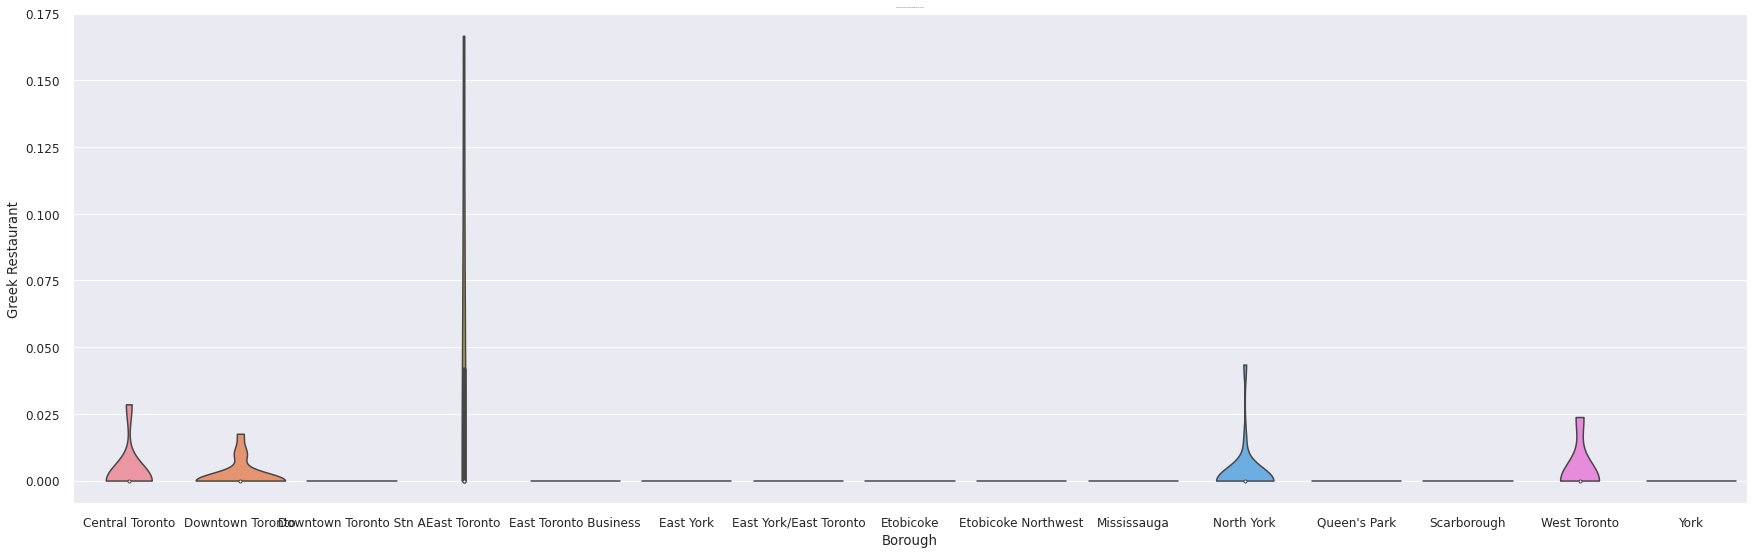

In [26]:
# Let's try Categorical plot 

%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns


fig = plt.figure(figsize=(30,9))

sns.set(font_scale=1.1)
sns.violinplot(y="Greek Restaurant", x="Borough", data=toronto_merged, cut=0);

plt.title('Violin plots of Greek restaurants in Borough of Toronto', fontsize=1)
plt.show()

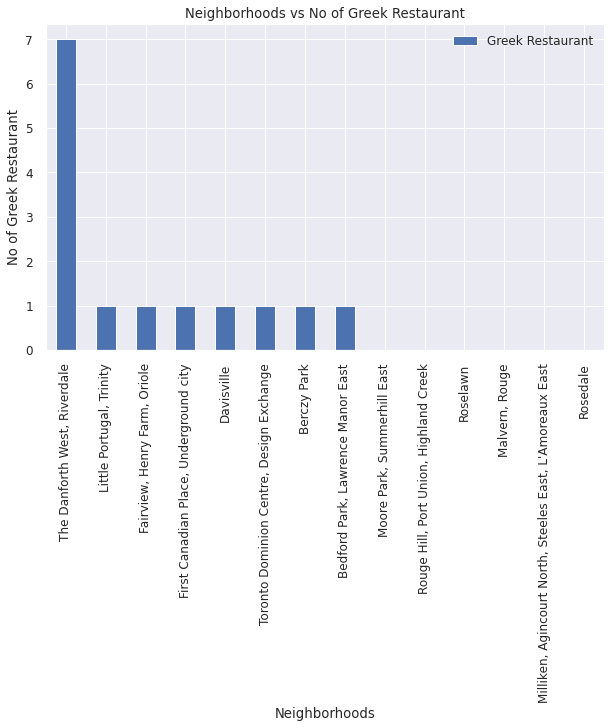

In [27]:
graph = pd.DataFrame(toronto_onehot.groupby('Neighborhood')['Greek Restaurant'].sum())
graph = graph.sort_values(by ='Greek Restaurant', ascending=False)
graph.iloc[:14].plot(kind='bar', figsize=(10,6))
plt.xlabel("Neighborhoods")
plt.ylabel("No of Greek Restaurant")
plt.title("Neighborhoods vs No of Greek Restaurant")
plt.show()

In [28]:
#Merge all the population table with the ethnic percentage by neighborhood
ET = ETY_population_df.append(TEY_population_df,sort=True).reset_index()
ET.drop('index',axis=1,inplace=True)
SN = North_population_df.append(Scar_population_df,sort=True).reset_index()
SN.drop('index',axis=1,inplace=True)
pop_ethnic_df = SN.append(ET,sort=True).reset_index()
pop_ethnic_df.drop('index',axis=1,inplace=True)
pop_ethnic_df = pop_ethnic_df[['Riding', 'Population','Ethnic Origin #1', 'Ethnic Origin 1 in %','Ethnic Origin #2', 'Ethnic Origin 2 in %',
                               'Ethnic Origin #3','Ethnic Origin 3 in %','Ethnic Origin #4', 'Ethnic Origin 4 in %','Ethnic Origin #5','Ethnic Origin 5 in %', 
                               'Ethnic Origin #6','Ethnic Origin 6 in %','Ethnic Origin #7', 'Ethnic Origin 7 in %','Ethnic Origin #8', 'Ethnic Origin 8 in %',
                               'Ethnic Origin #9','Ethnic Origin 9 in %',
                              ]]
pop_ethnic_df

,Riding,Population,Ethnic Origin #1,Ethnic Origin 1 in %,Ethnic Origin #2,Ethnic Origin 2 in %,Ethnic Origin #3,Ethnic Origin 3 in %,Ethnic Origin #4,Ethnic Origin 4 in %,Ethnic Origin #5,Ethnic Origin 5 in %,Ethnic Origin #6,Ethnic Origin 6 in %,Ethnic Origin #7,Ethnic Origin 7 in %,Ethnic Origin #8,Ethnic Origin 8 in %,Ethnic Origin #9,Ethnic Origin 9 in %
0,Willowdale,117405,Chinese,25.9,Iranian,12.1,Korean,10.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Eglinton-Lawrence,112925,Canadian,14.7,English,12.6,Polish,12.0,Filipino,11.0,Scottish,9.7,Italian,9.50,Irish,9.2,Russian,8.4,NaN,NaN
2,Don Valley North,109060,Chinese,32.4,East Indian,7.3,Iranian,7.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Humber River-Black Creek,107725,Italian,12.8,East Indian,9.2,Jamaican,8.5,Vietnamese,8.0,Canadian,7.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,York Centre,103760,Filipino,17.0,Italian,13.4,Russian,9.5,Canadian,8.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Don Valley West,101790,English,19.2,Canadian,15.1,Scottish,14.9,Irish,14.2,Chinese,11.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Don Valley East,93170,East Indian,10.6,Canadian,10.4,English,10.1,Chinese,8.9,Irish,8.1,Scottish,8.00,Filipino,7.8,NaN,NaN,NaN,NaN
7,Scarborough Centre,110450,Filipino,13.1,East Indian,12.2,Canadian,11.2,Chinese,10.7,English,7.8,Sri Lankan,7.00,NaN,NaN,NaN,NaN,NaN,NaN
8,Scarborough Southwest,108295,Canadian,16.2,English,14.3,Irish,11.5,Scottish,10.9,Filipino,9.5,East Indian,8.20,Chinese,7.2,NaN,NaN,NaN,NaN
9,Scarborough-Agincourt,104225,Chinese,47.0,East Indian,7.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
#Filtering the riding with Greek ethnic crowd
temp = pop_ethnic_df.loc[(pop_ethnic_df['Ethnic Origin #1'] == 'Greek')| 
                                      (pop_ethnic_df['Ethnic Origin #2'] == 'Greek')|
                                      (pop_ethnic_df['Ethnic Origin #3'] == 'Greek')|
                                      (pop_ethnic_df['Ethnic Origin #4'] == 'Greek')|
                                      (pop_ethnic_df['Ethnic Origin #5'] == 'Greek')|
                                      (pop_ethnic_df['Ethnic Origin #6'] == 'Greek')|
                                      (pop_ethnic_df['Ethnic Origin #7'] == 'Greek')|
                                      (pop_ethnic_df['Ethnic Origin #8'] == 'Greek')|
                                      (pop_ethnic_df['Ethnic Origin #9'] == 'Greek')]
pop_greek_df = pd.DataFrame(temp).reset_index()
pop_greek_df.drop('index',axis=1,inplace=True)

pop_greek_df

,Riding,Population,Ethnic Origin #1,Ethnic Origin 1 in %,Ethnic Origin #2,Ethnic Origin 2 in %,Ethnic Origin #3,Ethnic Origin 3 in %,Ethnic Origin #4,Ethnic Origin 4 in %,Ethnic Origin #5,Ethnic Origin 5 in %,Ethnic Origin #6,Ethnic Origin 6 in %,Ethnic Origin #7,Ethnic Origin 7 in %,Ethnic Origin #8,Ethnic Origin 8 in %,Ethnic Origin #9,Ethnic Origin 9 in %
0,Toronto-Danforth,105395,English,22.9,Irish,19.5,Scottish,18.7,Canadian,18.4,Chinese,13.8,French,8.86,German,8.8,Greek,7.3,NaN,NaN


In [30]:
#retaining only Greek ethnic percentage & the neighborhood name 
columns_list = pop_greek_df.columns.to_list()
pop_greek_DF_with_percent = pd.DataFrame()
#removing Riding & Population from the column names list
del columns_list[0]
del columns_list[0]


for i in range(0,pop_greek_df.shape[0]):
    for j in columns_list:
        print(j)
        if pop_greek_df.at[i, j] == 'Greek':
            k = columns_list.index(j) + 1
            percent_col = columns_list[k]
            pop_greek_DF_with_percent = pop_greek_DF_with_percent.append({'Riding':pop_greek_df.at[i, 'Riding'], 'Population':pop_greek_df.at[i, 'Population']
                                                                           , 'Ethnicity': pop_greek_df.at[i, j], 'Percentage': pop_greek_df.at[i, percent_col]},ignore_index=True)

pop_greek_DF_with_percent    

Ethnic Origin #1
Ethnic Origin 1 in %
Ethnic Origin #2
Ethnic Origin 2 in %
Ethnic Origin #3
Ethnic Origin 3 in %
Ethnic Origin #4
Ethnic Origin 4 in %
Ethnic Origin #5
Ethnic Origin 5 in %
Ethnic Origin #6
Ethnic Origin 6 in %
Ethnic Origin #7
Ethnic Origin 7 in %
Ethnic Origin #8
Ethnic Origin 8 in %
Ethnic Origin #9
Ethnic Origin 9 in %


,Ethnicity,Percentage,Population,Riding
0,Greek,7.3,105395.0,Toronto-Danforth


In [31]:
pop_greek_DF_with_percent['Greek Population'] = (pop_greek_DF_with_percent['Percentage'] * pop_greek_DF_with_percent['Population'])/100
pop_greek_DF_with_percent.drop(columns={'Percentage','Population','Ethnicity'},axis=1, inplace =True)
pop_greek_DF_with_percent.drop_duplicates(keep='first',inplace=True) 
pop_greek_DF_with_percent

,Riding,Greek Population
0,Toronto-Danforth,7693.835


### Relationship between Greek population and Greek restaurant

In [32]:
riding_list = pop_greek_DF_with_percent['Riding'].to_list()

riding_list

['Toronto-Danforth']

In [33]:
# Postal codes from Toronto-Danforth (retrieved by http://www.ezpostalcodes.com/street/ONTARIO/TORONTO/DANFORTH to .csv)
body = client_d1ca3a3a7a4c4648a5bbfeacb505741f.get_object(Bucket='courseracapstone-donotdelete-pr-6tyk5adzxihtdi',Key='Postal_codes_Toronto-Danforth.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_3 = pd.read_csv(body)
df_data_3.head()


,PostalCodesTorontoDanforth
0,M4C
1,M4J
2,M4K


In [34]:
df_data_3 = df_data_3.rename(columns = {'PostalCodesTorontoDanforth': 'PostalCode'}, inplace = False)

In [35]:
Riding_neighborhood_df = pd.merge(df_data_3, toronto_merged,
                        how="left", on=["PostalCode"])
Riding_neighborhood_df.head()


,PostalCode,Borough,Neighborhood,Latitude,Longitude,Greek Restaurant
0,M4C,East York,Woodbine Heights,43.695344,-79.318389,0.000000
1,M4J,East York/East Toronto,The Danforth East,43.685347,-79.338106,0.000000
2,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188,0.166667


In [36]:

# Declare a list that is to be converted into a column
Riding = ['Toronto-Danforth', 'Toronto-Danforth', 'Toronto-Danforth']

# Using 'Address' as the column name
# and equating it to the list
Riding_neighborhood_df['Riding'] = Riding

# Observe the result
Riding_neighborhood_df


,PostalCode,Borough,Neighborhood,Latitude,Longitude,Greek Restaurant,Riding
0,M4C,East York,Woodbine Heights,43.695344,-79.318389,0.000000,Toronto-Danforth
1,M4J,East York/East Toronto,The Danforth East,43.685347,-79.338106,0.000000,Toronto-Danforth
2,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188,0.166667,Toronto-Danforth


In [37]:
#Merging the pop_greek_DF_with_percent dataframe containing population information with the Riding_neighborhood_df dataframe.

Neigh_pop = pd.merge(pop_greek_DF_with_percent, Riding_neighborhood_df, on='Riding')

Neigh_pop.drop(columns=['Riding'],inplace =True)


In [38]:
Neigh_pop = Neigh_pop[['Greek Population','Neighborhood']]

In [39]:
Neigh_pop['split_neighborhoods'] = Neigh_pop['Neighborhood'].str.split(',') 
Neigh_pop.drop(columns=['Neighborhood'],inplace=True,axis=1)
Neigh_pop = Neigh_pop.split_neighborhoods.apply(pd.Series).merge(Neigh_pop, left_index = True, right_index = True).drop(["split_neighborhoods"], axis = 1)\
                    .melt(id_vars = ['Greek Population'], value_name = "Neighborhood").drop("variable", axis = 1).dropna()

Neigh_pop.reset_index()
Neigh_pop

,Greek Population,Neighborhood
0,7693.835,Woodbine Heights
1,7693.835,The Danforth East
2,7693.835,The Danforth West
5,7693.835,Riverdale


In [40]:
toronto_part['split_neighborhoods'] = toronto_part['Neighborhood'].str.split(',') 
toronto_part.drop(columns=['Neighborhood'],inplace=True,axis=1)
toronto_part = toronto_part.split_neighborhoods.apply(pd.Series).merge(toronto_part, left_index = True, right_index = True).drop(["split_neighborhoods"], axis = 1)\
                    .melt(id_vars = ['Greek Restaurant'], value_name = "Neighborhood").drop("variable", axis = 1).dropna()

toronto_part.reset_index()
toronto_part

/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Greek Restaurant,Neighborhood
0,0.000000,Agincourt
1,0.000000,Alderwood
2,0.000000,Bathurst Manor
3,0.000000,Bayview Village
4,0.043478,Bedford Park
5,0.017544,Berczy Park
6,0.000000,Birch Cliff
7,0.000000,Brockton
8,0.000000,CN Tower
9,0.000000,Caledonia-Fairbanks


In [41]:
pop_merged_restaurant_percent = pd.merge(Neigh_pop, toronto_part, on='Neighborhood')
pop_merged_restaurant_percent.head()

,Greek Population,Neighborhood,Greek Restaurant
0,7693.835,Woodbine Heights,0.000000
1,7693.835,The Danforth East,0.000000
2,7693.835,The Danforth West,0.166667
3,7693.835,Riverdale,0.166667


/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/ipykernel/__main__.py:9: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (9). Possibly due to duplicate points in X.
/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/ipykernel/__main__.py:9: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (10). Possibly due to duplicate points in X.


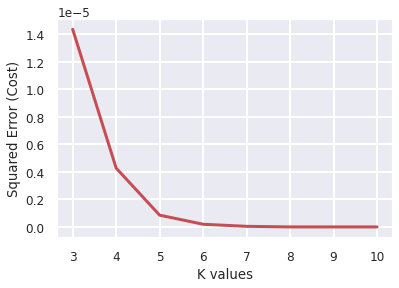

In [42]:
toronto_part_clustering = toronto_part.drop('Neighborhood', 1)


error_cost = []

for i in range(3,11):
    KM = KMeans(n_clusters = i, max_iter = 100)
    try:
        KM.fit(toronto_part_clustering)
    except ValueError:
        print("error on line",i)
    
    
    
    
    #calculate squared error for the clustered points
    error_cost.append(KM.inertia_/100)

#plot the K values aganist the squared error cost
plt.plot(range(3,11), error_cost, color='r', linewidth='3')
plt.xlabel('K values')
plt.ylabel('Squared Error (Cost)')
plt.grid(color='white', linestyle='-', linewidth=2)
plt.show()

/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/yellowbrick/cluster/elbow.py:312: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  self.estimator.fit(X, **kwargs)
/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/yellowbrick/cluster/elbow.py:312: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.estimator.fit(X, **kwargs)
/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/yellowbrick/cluster/elbow.py:312: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (11). Possibly due to duplicate points in X.
  self.estimator.fit(X, **kwargs)
/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/yellowbrick/cluster/elbow.py:312: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (12). Possibly due to duplicate points in X.
  self.

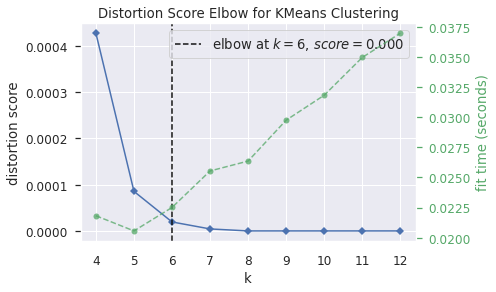

In [43]:
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(4,13))

visualizer.fit(toronto_part_clustering)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [44]:
kclusters = 6

toronto_part_clustering = toronto_part.drop('Neighborhood', 1)

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_part_clustering)

kmeans.labels_

array([0, 0, 0, 0, 4, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 3,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 5, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 3, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [45]:
#sorted_neighborhoods_venues.drop(['Cluster Labels'],axis=1,inplace=True)
toronto_part.insert(0, 'Cluster Labels', kmeans.labels_)
toronto_merged = df
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(toronto_part.set_index('Neighborhood'), on='Neighborhood')
toronto_merged.dropna(subset=["Cluster Labels"], axis=0, inplace=True)
toronto_merged.reset_index(drop=True, inplace=True)
toronto_merged['Cluster Labels'].astype(int)
toronto_merged.head()

,Borough,PostalCode,Neighborhood,Latitude,Longitude,Cluster Labels,Greek Restaurant
0,Central Toronto,M4N,Lawrence Park,43.728020,-79.388790,0.0,0.000000
1,Central Toronto,M4P,Davisville North,43.712751,-79.390197,0.0,0.000000
2,Central Toronto,M4R,North Toronto West,43.715383,-79.405678,0.0,0.000000
3,Central Toronto,M4S,Davisville,43.704324,-79.388790,2.0,0.028571
4,Central Toronto,M5N,Roselawn,43.711695,-79.416936,0.0,0.000000


In [46]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11, width='90%', height='70%')

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels'].astype(int)):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
map_clusters

In [47]:
#Cluster 0
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0]

,Borough,PostalCode,Neighborhood,Latitude,Longitude,Cluster Labels,Greek Restaurant
0,Central Toronto,M4N,Lawrence Park,43.728020,-79.388790,0.0,0.0
1,Central Toronto,M4P,Davisville North,43.712751,-79.390197,0.0,0.0
2,Central Toronto,M4R,North Toronto West,43.715383,-79.405678,0.0,0.0
4,Central Toronto,M5N,Roselawn,43.711695,-79.416936,0.0,0.0
5,Central Toronto,M5P,Forest Hill North & West,43.696948,-79.411307,0.0,0.0
6,Downtown Toronto,M4W,Rosedale,43.679563,-79.377529,0.0,0.0
7,Downtown Toronto,M4Y,Church and Wellesley,43.665860,-79.383160,0.0,0.0
8,Downtown Toronto,M5C,St. James Town,43.651494,-79.375418,0.0,0.0
9,Downtown Toronto,M5C,St. James Town,43.651494,-79.375418,0.0,0.0
11,Downtown Toronto,M5G,Central Bay Street,43.657952,-79.387383,0.0,0.0


In [48]:
#Cluster 1
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1]

,Borough,PostalCode,Neighborhood,Latitude,Longitude,Cluster Labels,Greek Restaurant


In [49]:
#Cluster 2
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2]

,Borough,PostalCode,Neighborhood,Latitude,Longitude,Cluster Labels,Greek Restaurant
3,Central Toronto,M4S,Davisville,43.704324,-79.38879,2.0,0.028571


In [50]:
#Cluster 3
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3]

,Borough,PostalCode,Neighborhood,Latitude,Longitude,Cluster Labels,Greek Restaurant


In [51]:
#Cluster 4
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4]

,Borough,PostalCode,Neighborhood,Latitude,Longitude,Cluster Labels,Greek Restaurant


In [52]:
#Cluster 5
toronto_merged.loc[toronto_merged['Cluster Labels'] == 5]

,Borough,PostalCode,Neighborhood,Latitude,Longitude,Cluster Labels,Greek Restaurant
10,Downtown Toronto,M5E,Berczy Park,43.644771,-79.373306,5.0,0.017544


### Results & Discussion <a name="results"></a>

Our analysis shows that although there is a great number of restaurants in the center of Toronto, there are a few Greek restaurant close to city center. Highest concentration of Greek restaurants was detected in the Boroughs of East Toronto, North York, Central Toronto, West Toronto and Downtown Toronto. The highest concentration of the Greek restaurants is in the neighborhoods of Danforth West, Riverdale of East Toronto.

According to Wikipedia, Greek population of Toronto is concentrated in the Riding of Toronto-Danforth with a population of 7.693 (7,3% of the Riding) and more specifically in the neighborhoods of Woodbine Heights, The Danforth East, The Danforth West and Riverdale.    

Based on the results of our analysis the neighborhoods of The Danforth West and Riverdale has both Greek restaurants but Woodbine Heights and Danforth East, has no Greek restaurants which indicates a promising opportunity for establishing a new Greek restaurant.

It should be mentioned that the available data regarding the population of Greek people in Toronto is from 2016 which may be considered as relatively old. The same project could run with the same scope when the population data from Wikipedia are updated.  

### Conclusion <a name="conclusion"></a>

Apparently, we can say that entreprenuers are able to spot opportunities and invest in the most promising areas like they already did with the cases of Danforth West and Riverdale, two areas with Greek people and Greek restaurants. However, entreprenuers can invest in the areas of Woodbine Heights and Danforth East where according to the available data and our analysis there are Greek people but there are no Greek restaurants.